《基于连续形状变换的声子晶体与光子晶体的能带结构及其排序》
示例代码2 ： 能带排序

Band sorting stage 1 complete. Sorted: 15, failed: 4, increase: 15
Band sorting stage 2 complete. Sorted: 19, failed: 0, increase: 4
Band sorting stage 3 complete. Sorted: 19, failed: 0, increase: 0
Band sorting stage 4 complete. Sorted: 19, failed: 0, increase: 0
Band sorting stage 5 complete. Sorted: 19, failed: 0, increase: 0
Band sorting time-consuming:0.42498988151550293 s


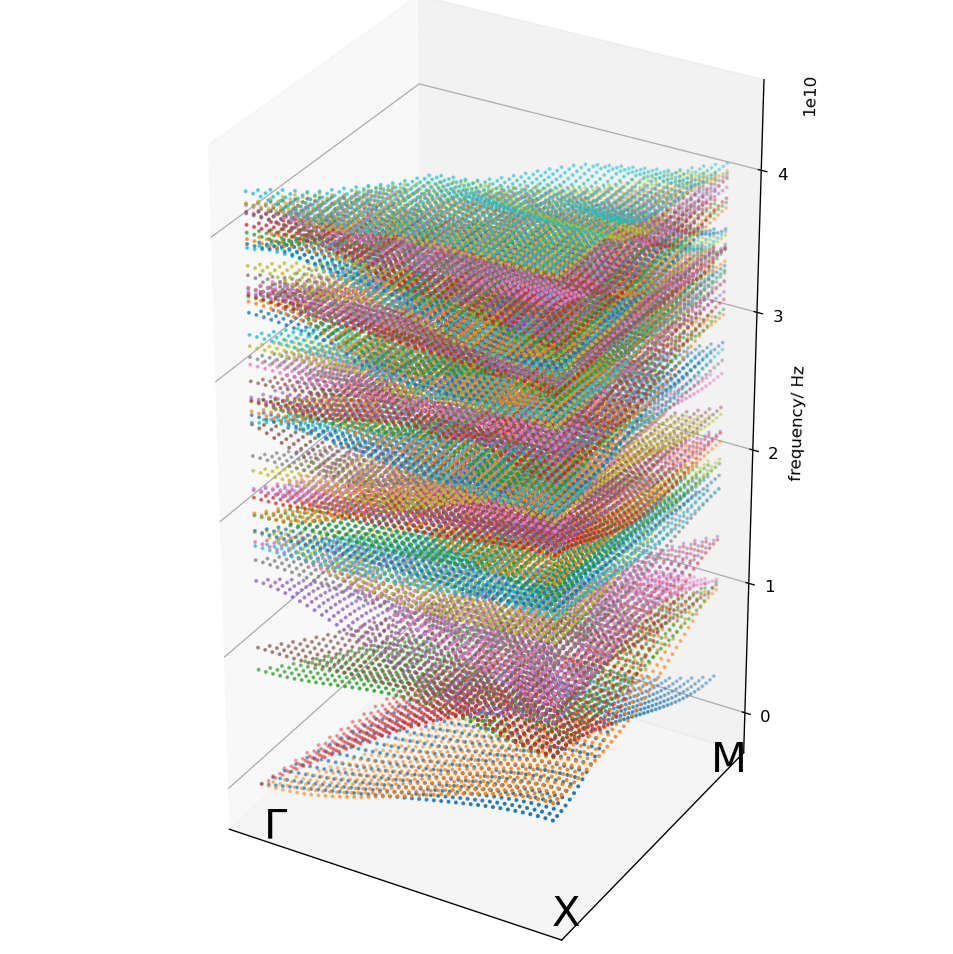

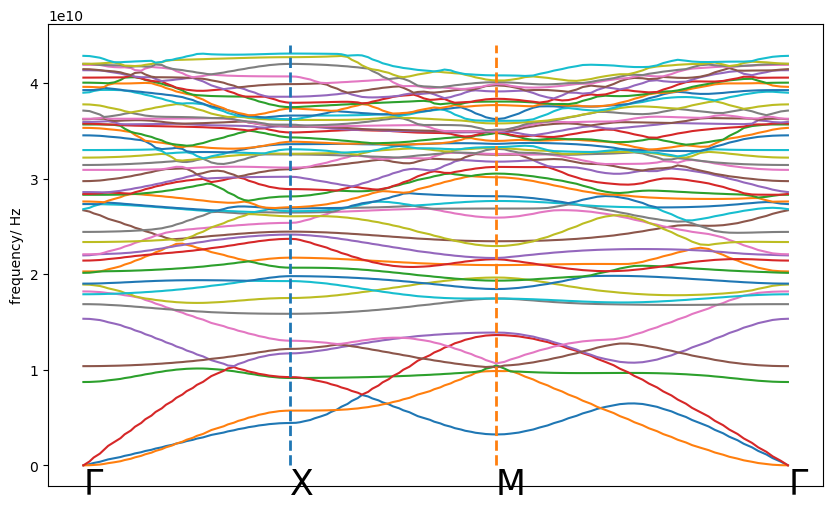

In [18]:
#(installing anaconda3 to include these libraries is recommended)
import numpy as np
import matplotlib.pyplot as mp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import copy
import gc
import time
import warnings
warnings.filterwarnings('ignore')

T=0.5                   #tempereture(K)
h=6.62e-34
kb=1.38e-23
intpl=0                 #2^intpl interpolation points in a deltak
thickness=2.2e-7        #thickness of the cell
deltaw=1e8              #frequency space dicretization distance
filetitle="this_example"     #filetitle should illustrate the character of a sorting task
num_bands_to_sort=19  #not larger than number of total bands
num_bands_to_show=50    #number of bands to plot (count from low frequency)

###Imoprt data###
with open('basic_info_%s.txt'%(filetitle),'rt') as raw_data:
    basic_info=np.loadtxt(raw_data,delimiter=' ',usecols=[i for i in range(4)])
with open('kpoints_original_x_%s.txt'%(filetitle),'rt') as raw_data:
    kx=np.loadtxt(raw_data,delimiter=' ',usecols=[i for i in range(int(basic_info[0]))])
with open('kpoints_original_y_%s.txt'%(filetitle),'rt') as raw_data:
    ky=np.loadtxt(raw_data,delimiter=' ',usecols=[i for i in range(int(basic_info[0]))])
with open('shift-lattice_%s.txt'%(filetitle),'rt') as raw_data:
    data_ori=np.loadtxt(raw_data,delimiter=',',skiprows=8)
data_ori=data_ori.T[1:len(data_ori)].T
if len(data_ori[:,0])!=len(kx):
    print("Size of input data abnormal")
    exit(0)
deltak0=basic_info[1]
a=basic_info[2]
b=basic_info[3]
num_bands=data_ori.shape[1]
Size=int(1/deltak0)
data=[[] for j in range(num_bands)]
for i in range(0,num_bands):
    for j in range(Size+1):
        data[i].append(data_ori.T[i][int(j*(2*(Size+1)+1-j)/2):int((j+1)*(2*(Size+1)-j)/2)].tolist())
data=np.array(data)[0:]
if num_bands>data.shape[0]:
    num_bands=data.shape[0]

### Band sorting ###
time1 = time.time()
dataReorder=copy.deepcopy(data)
stage=0
num_failed=[num_bands_to_sort]
failed_bands_indexes=[range(num_bands_to_sort)]
def closest(list, target):
    a=[]
    for i in list:
        a.append(abs(target-i))
    return a.index(min(a))
def closest2(list, target):
    a=[]
    for i in list:
        a.append(abs(target-i))
    del a[a.index(min(a))]
    return a.index(min(a))
def predict(i, y, x, data_to_sort, data_obtained, search_list, target):
    position=closest([data_to_sort[i][y][x] for i in search_list], target)
    data_obtained[i][y][x]=data_to_sort[search_list[position]][y][x]
    data_to_sort[search_list[position]][y][x]=1e16
def predict2(i, y, x, data_to_sort, data_obtained, search_list, target_list):
    predict_list=[]
    for n in target_list:
        predict_list.append(closest([data_to_sort[i][y][x] for i in search_list], n))
    position=max(predict_list,key=predict_list.count)
    data_obtained[i][y][x]=data_to_sort[search_list[position]][y][x]
    data_to_sort[search_list[position]][y][x]=1e18
def checkBands(stage,dataReorder,num_failed,failed_bands_indexes):
    gradw=[[] for i in range(num_failed[stage])]
    grad2w=[[] for i in range(num_failed[stage])]
    grad2w_flatten=[[] for i in range(num_failed[stage])]
    failed_bands_indexes.append([])
    for i in range(num_failed[stage]):
        gradw[i]=copy.deepcopy(np.delete(dataReorder[i],0,-1))
        I=failed_bands_indexes[stage][i]
        for y in range(Size):
            for x in range(Size-y):
                    gradw[i][y][x]=(dataReorder[I][y][x+1]-dataReorder[I][y][x])+(dataReorder[I][y+1][x]-dataReorder[I][y][x+1])
        grad2w[i]=copy.deepcopy(np.delete(gradw[i],0,-1))
        for y in range(Size-1):
            for x in range(Size-1-y):
                    grad2w[i][y][x]=(gradw[i][y][x+1]-gradw[i][y][x])+(gradw[i][y+1][x]-gradw[i][y][x])
        grad2w_flatten[i]=np.hstack(grad2w[i])
        if max(grad2w_flatten[i])>5e8:
            failed_bands_indexes[stage+1].append(failed_bands_indexes[stage][i])
    num_failed.append(len(failed_bands_indexes[stage+1]))
    print('Band sorting stage %d complete. Sorted: %d, failed: %d, increase: %d'%(stage+1,num_bands_to_sort-num_failed[stage+1],num_failed[stage+1],num_failed[stage]-num_failed[stage+1]))

#Band sorting strategy 1
data_temp=copy.deepcopy(dataReorder)
for i in failed_bands_indexes[stage]:
    search_list=range(min(num_bands_to_sort,i+15))
    #search_list=range(num_bands_to_smooth)
    startWith=int(Size/15)
    for x in [Size-X-startWith-1 for X in range(1,Size-startWith)]:
        predict(i, startWith, x, data_temp, dataReorder, search_list, 2*dataReorder[i][startWith][x+1]-dataReorder[i][startWith][x+2])
    for y in range(max(startWith+1,2),Size-startWith+1):
        predict(i, y, -startWith-1, data_temp, dataReorder, search_list, 2*dataReorder[i][y-1][-startWith-1]-dataReorder[i][y-2][-startWith-1])
    for x in [X-startWith for X in range(startWith)]:
        for y in range(max(-x+1,2),Size+1+x):
            predict_y=2*dataReorder[i][y-1][x]-dataReorder[i][y-2][x]
            predict(i, y, x, data_temp, dataReorder, search_list, (dataReorder[i][y][x-1]+predict_y)/2)
        predict(i, Size+1+x, x, data_temp, dataReorder, search_list, 2*dataReorder[i][Size+x][x]-dataReorder[i][Size-1+x][x])
    for y in [startWith-1-Y for Y in range(startWith)]:
        for x in [Size-X-y for X in range(1,Size-y)]:
            predict_xy=dataReorder[i][y+1][x-1]+dataReorder[i][y][x+1]-dataReorder[i][y+1][x]
            predict(i, y, x, data_temp, dataReorder, search_list, predict_xy)
        predict(i, y, 0, data_temp, dataReorder, search_list, 2*dataReorder[i][y][1]-dataReorder[i][y][2])
    for y in range(startWith+1,Size+1):
        for x in [Size-X-y for X in range(startWith+1,Size+1-y)]:
            predict_x=2*dataReorder[i][y][x+1]-dataReorder[i][y][x+2]
            predict_y=2*dataReorder[i][y-1][x]-dataReorder[i][y-2][x]
            predict_xy=dataReorder[i][y][x+1]+dataReorder[i][y-1][x+1]-dataReorder[i][y-1][x+2]
            predict_xy2=2*dataReorder[i][y-1][x]-dataReorder[i][y-2][x]
            predict_xy3=2*dataReorder[i][y-1][x+2]-dataReorder[i][y-2][x+4]
            #predict(i, y, x, data_temp, dataReorder, search_list, (predict_x+predict_y+predict_xy+predict_xy2)/4)
            predict2(i, y, x, data_temp, dataReorder, search_list, [predict_x,predict_y,predict_xy,predict_xy3])
checkBands(stage,dataReorder,num_failed,failed_bands_indexes)
stage=stage+1
#Band sorting strategy 2
data_temp=copy.deepcopy(dataReorder)
for i in failed_bands_indexes[stage]:
    search_list=failed_bands_indexes[stage][:min(i+15,num_failed[-1])]
    position=closest([data_temp[i][1][0] for i in search_list], dataReorder[i][0][0])
    dataReorder[i][1][0]=data_temp[search_list[position]][1][0]
    data_temp[search_list[position]][1][0]=1e18
    for y in range(2,Size+1):
        predict(i, y, 0, data_temp, dataReorder, search_list, 2*dataReorder[i][y-1][0]-dataReorder[i][y-2][0])
    for y in range(Size):
        predict(i, y, 1, data_temp, dataReorder, search_list, (dataReorder[i][y+1][0]+dataReorder[i][y][0])/2)
    for x in range(2,Size+1):
        for y in range(Size+1-x):
            predict_x=2*dataReorder[i][y][x-1]-dataReorder[i][y][x-2]
            predict_y=2*dataReorder[i][y+1][x-1]-dataReorder[i][y+2][x-2]
            predict_xy=dataReorder[i][y+1][x-1]+dataReorder[i][y][x-1]-dataReorder[i][y+1][x-2]
            #predict2(i, y, x, data_temp, dataReorder, search_list, [predict_x,predict_y,predict_xy])
            predict(i, y, x, data_temp, dataReorder, search_list, predict_xy)
checkBands(stage,dataReorder,num_failed,failed_bands_indexes)
stage=stage+1
#Band sorting strategy 3
data_temp=copy.deepcopy(dataReorder)
for i in failed_bands_indexes[stage]:
    search_list=failed_bands_indexes[stage][:min(i+15,num_failed[-1])]
    predict(i, Size-1, 0, data_temp, dataReorder, search_list, dataReorder[i][Size][0])
    for y in range(Size-2,-1,-1):
        predict(i, y, 0, data_temp, dataReorder, search_list, 2*dataReorder[i][y+1][0]-dataReorder[i][y+2][0])
    for y in range(Size):
        predict(i, y, 1, data_temp, dataReorder, search_list, (dataReorder[i][y+1][0]+dataReorder[i][y][0])/2)
    for x in range(2,Size+1):
        for y in range(Size+1-x):
            predict_x=2*dataReorder[i][y][x-1]-dataReorder[i][y][x-2]
            predict_y=2*dataReorder[i][y+1][x-1]-dataReorder[i][y+2][x-2]
            predict_xy=dataReorder[i][y+1][x-1]+dataReorder[i][y][x-1]-dataReorder[i][y+1][x-2]
            predict2(i, y, x, data_temp, dataReorder, search_list, [predict_x,predict_y,predict_xy])
checkBands(stage,dataReorder,num_failed,failed_bands_indexes)
stage=stage+1
#Band sorting strategy 4
for i in failed_bands_indexes[stage]:
    for y in range(Size+1):
        dataReorder[i][y]=np.array(dataReorder[i][y])**2
data_temp=copy.deepcopy(dataReorder)
startWith=2
for i in failed_bands_indexes[stage]:
    search_list=failed_bands_indexes[stage][:min(i+15,num_failed[-1])]
    #for y in range(2,Size+1-startWith):
    for y in range(Size-startWith-2,-1,-1):
        predict(i, y, startWith, data_temp, dataReorder, search_list, 2*dataReorder[i][y+1][startWith]-dataReorder[i][y+2][startWith])
    for x in range(startWith-1,-1,-1):
        for y in range(1,Size-x):
            predict(i, y, x, data_temp, dataReorder, search_list, (dataReorder[i][y-1][x]+dataReorder[i][y][x+1])/2)
        predict(i, 0, x, data_temp, dataReorder, search_list, 2*dataReorder[i][1][x]-dataReorder[i][2][x])
        predict(i, Size-x, x, data_temp, dataReorder, search_list, 2*dataReorder[i][Size-x-1][x]-dataReorder[i][Size-x-2][x])
    for x in range(startWith+1,Size+1):
        for y in range(Size+1-x):
            predict_x=2*dataReorder[i][y][x-1]-dataReorder[i][y][x-2]
            predict_y=2*dataReorder[i][y+1][x-1]-dataReorder[i][y+2][x-2]
            predict_xy=dataReorder[i][y+1][x-1]+dataReorder[i][y][x-1]-dataReorder[i][y+1][x-2]
            #predict2(i, y, x, data_temp, dataReorder, search_list, [predict_x,predict_y,predict_xy])
            predict(i, y, x, data_temp, dataReorder, search_list, predict_xy)
for i in failed_bands_indexes[stage]:
    for y in range(Size+1):
        dataReorder[i][y]=np.sqrt(dataReorder[i][y]).tolist()
checkBands(stage,dataReorder,num_failed,failed_bands_indexes)
stage=stage+1
#Band sorting strategy 5
for i in failed_bands_indexes[stage]:
    for y in range(Size+1):
        dataReorder[i][y]=np.array(dataReorder[i][y])**2
data_temp=copy.deepcopy(dataReorder)
startWith=2
for i in failed_bands_indexes[stage]:
    search_list=failed_bands_indexes[stage][:min(i+15,num_failed[-1])]
    #for y in range(2,Size+1-startWith):
    for y in range(Size-startWith-2,-1,-1):
        position=closest([data_temp[i][y][startWith] for i in search_list], 2*dataReorder[i][y+1][startWith]-dataReorder[i][y+2][startWith])
        dataReorder[i][y][startWith]=data_temp[search_list[position]][y][startWith]
        data_temp[search_list[position]][y][startWith]=1e18
    for x in range(startWith-1,-1,-1):
        for y in range(1,Size-x):
            position=closest([data_temp[i][y][x] for i in search_list], (dataReorder[i][y-1][x]+dataReorder[i][y][x+1])/2)
            dataReorder[i][y][x]=data_temp[search_list[position]][y][x]
            data_temp[search_list[position]][y][x]=1e18
        position=closest([data_temp[i][0][x] for i in search_list], 2*dataReorder[i][1][x]-dataReorder[i][2][x])
        dataReorder[i][0][x]=data_temp[search_list[position]][0][x]
        data_temp[search_list[position]][0][x]=1e18
        position=closest([data_temp[i][Size-x][x] for i in search_list], 2*dataReorder[i][Size-x-1][x]-dataReorder[i][Size-x-2][x])
        dataReorder[i][Size-x][x]=data_temp[search_list[position]][Size-x][x]
        data_temp[search_list[position]][Size-x][x]=1e18
    for x in range(startWith+1,Size+1):
        for y in range(Size+1-x):
            predict_x=2*dataReorder[i][y][x-1]-dataReorder[i][y][x-2]
            predict_y=2*dataReorder[i][y+1][x-1]-dataReorder[i][y+2][x-2]
            predict_xy=dataReorder[i][y+1][x-1]+dataReorder[i][y][x-1]-dataReorder[i][y+1][x-2]
            predict_list=[]
            for n in [predict_x,predict_y,predict_xy]:
                predict_list.append(closest([data_temp[i][y][x] for i in search_list], n))
            position=max(predict_list,key=predict_list.count)
            dataReorder[i][y][x]=data_temp[search_list[position]][y][x]
            data_temp[search_list[position]][y][x]=1e18
for i in failed_bands_indexes[stage]:
    for y in range(Size+1):
        dataReorder[i][y]=np.sqrt(dataReorder[i][y]).tolist()
checkBands(stage,dataReorder,num_failed,failed_bands_indexes)
stage=stage+1

time2 = time.time()
print('Band sorting time-consuming:%s s' % (time2-time1))
            
###Interpolate the data###
if intpl>0:
    intpl=int(intpl)
    data_intpl=[[[]]*num_bands for l in range(intpl+1)]
    data_intpl[0]=dataReorder
    for n in range(1,intpl+1):
        for i in range(num_bands):
            data_intpl[n][i]=[[]]*(Size*2**n+1)
    for n in range(1,intpl+1):
        for i in range(num_bands):
            for y in range(Size*2**n+1):
                data_intpl[n][i][y]=[[]]*(Size*2**n-y+1)
    for n in range(1,intpl+1):
        for i in range(num_bands):
            for y in range(Size*2**n+1):
                for x in range(Size*2**n-y+1):
                    if int(y/2)==y/2 and int(x/2)==x/2:
                        data_intpl[n][i][y][x]=data_intpl[n-1][i][int(y/2)][int(x/2)]
                    elif int(y/2)==y/2 and int(x/2)!=x/2:
                        data_intpl[n][i][y][x]=(data_intpl[n-1][i][int(y/2)][int(x/2)]+data_intpl[n-1][i][int(y/2)][int(x/2)+1])/2
                    elif int(y/2)!=y/2 and int(x/2)==x/2:
                        data_intpl[n][i][y][x]=(data_intpl[n-1][i][int(y/2)][int(x/2)]+data_intpl[n-1][i][int(y/2)+1][int(x/2)])/2
                    else:
                        data_intpl[n][i][y][x]=(data_intpl[n-1][i][int(y/2)][int(x/2)+1]+data_intpl[n-1][i][int(y/2)+1][int(x/2)])/2
        #del data_intpl[n-1]
        #gc.collect()
    data_intpl=data_intpl[n]
else:
    data_intpl=dataReorder
data_intpl_flat=[]
for i in range(num_bands):
    data_intpl_flat.append(sum(data_intpl[i],[]))
kx_intpl=[]
ky_intpl=[]
Size2=Size*2**intpl
for i in range(0,Size2+1):
    for j in range(i,Size2+1):
        kx_intpl.append(j*deltak0/2**intpl*np.pi/a)
        ky_intpl.append(i*deltak0/2**intpl*np.pi/b)
data_intpl_flat2=sum(data_intpl_flat,[])
data_intpl_flat3=[]
for i in range(num_bands):
    data_intpl_flat3.append(data_intpl_flat[i][Size*2**intpl+1:])
data_intpl_flat4=sum(data_intpl_flat3,[])
total_points=len(data_intpl_flat2)
freq_space=[float("%.4f" % (deltaw*i)) for i in range(0,int(max(data_intpl_flat2)*0.99/deltaw))]

###Plot the result###
plt.rcParams['figure.figsize'] = (10,30)
plt.figure( dpi=120)
axes=mp.gca(projection="3d")
plt.xticks([])
plt.yticks([])
plt.gca().set_box_aspect((1, 1, 2))
for i in range(num_bands_to_show):
    #axes.scatter(kx, ky, data_ori[:,i], cmap="jet", marker="o",s=2)
    axes.scatter(kx, ky, sum(dataReorder[i],[]), cmap="jet", marker="o",s=2)
    #axes.scatter(kx_intpl, ky_intpl, data_intpl_flat[i], cmap="jet", marker="o",s=1, alpha=0.9)
Max=max(data_intpl_flat[num_bands_to_show-1])
axes.tick_params(axis='z',labelsize=10)
axes.text(0,0,-Max/10,r"$\Gamma$",size=25)
axes.text(kx_intpl[-1],0,-Max/12,"X",size=25)
axes.text(kx_intpl[-1],ky_intpl[-1],-Max/10,"M",size=25)
axes.set_zlabel('frequency/ Hz')
plt.show()

data_path=[[] for i in range(num_bands)]
for i in range(num_bands):
    for k in range(Size):
        data_path[i].append(dataReorder[i][0][k])
    for k in range(Size):
        data_path[i].append(dataReorder[i][k][Size-k])
    for k in range(Size):
        data_path[i].append(dataReorder[i][Size-k][0])
    data_path[i].append(data_path[i][0])
kspace_1D=[float("%.2f" %(deltak0*i)) for i in range(2*Size)]+[float("%.2f" %(2+deltak0*np.sqrt(2)*i)) for i in range(Size)]+[2+np.sqrt(2)]
plt.rcParams['figure.figsize'] = (10,6)
for i in range(0,num_bands_to_show):
    plt.plot(kspace_1D,data_path[i])
Max=(1+1/num_bands_to_show)*max(data_path[num_bands_to_show-1])
plt.plot([kspace_1D[Size],kspace_1D[Size]], [0,Max], linestyle='--', linewidth=2.0)
plt.plot([kspace_1D[2*Size],kspace_1D[2*Size]], [0,Max], linestyle='--', linewidth=2.0)
plt.ylabel("frequency/ Hz")
plt.text(0,-3e9,r"$\Gamma$",size=25)
plt.text(kspace_1D[Size],-3e9,"X",size=25)
plt.text(kspace_1D[2*Size],-3e9,"M",size=25)
plt.text(kspace_1D[-1],-3e9,r"$\Gamma$",size=25)
plt.xticks([])
plt.show()

if 0:       #if 1, output bands,kx,ky
    np.savetxt("kx.csv",np.array(kx),delimiter=',', newline='\n', fmt='%f')
    np.savetxt("ky.csv",np.array(ky),delimiter=',', newline='\n', fmt='%f')
    np.savetxt("bands_%s.csv"%(filetitle),np.array(sum(dataReorder[i],[])),delimiter=',', newline='\n', fmt='%f')

if 1:       #if 1, output interpolated bands,kx,ky
    np.savetxt("kx_intpl.csv",np.array(kx_intpl),delimiter=',', newline='\n', fmt='%f')
    np.savetxt("ky_intpl.csv",np.array(ky_intpl),delimiter=',', newline='\n', fmt='%f')
    np.savetxt("data_intpl_flat.csv",np.array(data_intpl_flat),delimiter=',', newline='\n', fmt='%f')

单线程0.4秒欸 ╮(￣▽￣)╭

Zoom-in method完成这19个能带的排序大概要额外增加 64核*一整天 的计算量来获得其它参数点上的本征频率